<a href="https://colab.research.google.com/github/KoeusIss/orvp/blob/main/0x02_fine_tune_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Light Gradient Boosting Model
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel, distributed, and GPU learning.
* Capable of handling large-scale data.

In this notebook, we will walk through a complete example of using automated hyperparameter tuning to optimize a _Light Gradient Boosting Model_. In particular, we will use Bayesian Optimization and the [Scikit Optimize](https://scikit-optimize.github.io/stable/index.html) library to tune the hyperparameters of the LGBM on the Optiver Realized Volatility Prediction competition.

* **Manual**: select hyperparameters based on intuition/experience/guessing, train the model with the hyperparameters, and score on the validation data. Repeat process until you run out of patience or are satisfied with the results.
* **Grid Search**: set up a grid of hyperparameter values and for each combination, train a model and score on the validation data. In this approach, every single combination of hyperparameters values is tried which can be very inefficient!
* **Random search**: set up a grid of hyperparameter values and select random combinations to train the model and score. The number of search iterations is set based on time/resources.
* **Automated Hyperparameter Tuning**: use methods such as gradient descent, Bayesian Optimization, or evolutionary algorithms to conduct a guided search for the best hyperparameters.


In [1]:
# Connect with GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# Utilities libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from skopt import load

# Fine tuning
import skopt
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence
from skopt.plots import plot_evaluations
from skopt.plots import plot_objective
from skopt.plots import plot_gaussian_process

# Models
import lightgbm as lgb

# Constant
N_FOLDS = 5

In [7]:
df = pd.read_csv("/content/drive/MyDrive/DS/optiver-realized-volatility-prediction/df_train_v0.csv")
df

,Unnamed: 0,stock_id,time_id,target,log_return_1_realized_volatility_s600,log_return_2_realized_volatility_s600,wap_1_mean_s600,wap_1_std_s600,wap_2_mean_s600,wap_2_std_s600,bid_price1_mean_s600,bid_price1_amax_s600,bid_price2_mean_s600,bid_price2_amax_s600,ask_price1_mean_s600,ask_price1_amin_s600,ask_price2_mean_s600,ask_price2_amin_s600,bid_size1_mean_s600,bid_size1_sum_s600,bid_size2_mean_s600,bid_size2_sum_s600,ask_size1_mean_s600,ask_size1_sum_s600,ask_size2_mean_s600,ask_size2_sum_s600,bid_spread_mean_s600,bid_spread_std_s600,ask_spread_mean_s600,ask_spread_std_s600,spread_price_2_mean_s600,spread_price_2_std_s600,wap_balance_mean_s600,wap_balance_std_s600,total_volume_mean_s600,total_volume_std_s600,log_return_1_realized_volatility_s540,log_return_2_realized_volatility_s540,wap_1_mean_s540,wap_1_std_s540,...,size_sum_s360,amount_mean_s360,amount_sum_s360,order_count_mean_s360,order_count_sum_s360,log_return_realized_volatility_s300,size_mean_s300,size_sum_s300,amount_mean_s300,amount_sum_s300,order_count_mean_s300,order_count_sum_s300,log_return_realized_volatility_s240,size_mean_s240,size_sum_s240,amount_mean_s240,amount_sum_s240,order_count_mean_s240,order_count_sum_s240,log_return_realized_volatility_s180,size_mean_s180,size_sum_s180,amount_mean_s180,amount_sum_s180,order_count_mean_s180,order_count_sum_s180,log_return_realized_volatility_s120,size_mean_s120,size_sum_s120,amount_mean_s120,amount_sum_s120,order_count_mean_s120,order_count_sum_s120,log_return_realized_volatility_s60,size_mean_s60,size_sum_s60,amount_mean_s60,amount_sum_s60,order_count_mean_s60,order_count_sum_s60
0,0,0,5,0.004136,0.004499,0.006999,1.003725,0.000693,1.003661,0.000781,1.003314,1.004267,1.003138,1.004215,1.004169,1.002301,1.004320,1.002353,78.264901,23636,80.880795,24426,74.579470,22523,89.771523,27111,0.000176,0.000162,-0.000151,0.000126,0.000588,0.000107,0.000388,0.000295,323.496689,138.101214,0.004186,0.006635,1.003875,0.000449,...,1796.0,72.099460,1802.4865,2.400000,60.0,0.001308,75.571429,1587.0,75.83908,1592.62070,2.571429,54.0,0.001271,79.200000,1584.0,79.480330,1589.60670,2.600000,52.0,0.001121,65.312500,1045.0,65.523590,1048.37740,2.437500,39.0,0.000993,67.181818,739.0,67.390650,741.297100,2.454545,27.0,0.000953,88.375000,707.0,88.646120,709.168950,2.750000,22.0
1,1,0,11,0.001445,0.001204,0.002476,1.000239,0.000262,1.000206,0.000272,1.000011,1.000627,0.999869,1.000477,1.000406,0.999975,1.000541,1.000176,149.965000,29993,95.445000,19089,71.145000,14229,94.895000,18979,0.000142,0.000148,-0.000135,0.000065,0.000335,0.000100,0.000212,0.000155,411.450000,172.263581,0.001165,0.002468,1.000250,0.000261,...,1122.0,53.445446,1122.3544,2.047619,43.0,0.000587,56.250000,900.0,56.27037,900.32590,2.250000,36.0,0.000557,62.357143,873.0,62.380142,873.32196,2.142857,30.0,0.000501,82.800000,828.0,82.830830,828.30830,2.200000,22.0,0.000496,103.250000,826.0,103.288475,826.307800,2.500000,20.0,0.000203,69.333333,208.0,69.376970,208.130900,2.666667,8.0
2,2,0,16,0.002168,0.002369,0.004801,0.999542,0.000864,0.999680,0.000862,0.999204,1.000120,0.999007,0.999928,0.999929,0.997678,1.000127,0.997966,96.132979,18073,114.526596,21531,131.037234,24635,74.654255,14035,0.000197,0.000170,-0.000198,0.000171,0.000560,0.000147,0.000331,0.000246,416.351064,138.433034,0.002218,0.004183,0.999424,0.000892,...,1482.0,98.648780,1479.7317,3.000000,45.0,0.001137,99.083333,1189.0,98.90628,1186.87540,3.166667,38.0,0.001048,108.700000,1087.0,108.492630,1084.92640,3.400000,34.0,0.001048,120.555556,1085.0,120.325264,1082.92740,3.666667,33.0,0.000820,97.285714,681.0,97.070890,679.496200,2.428571,17.0,0.000325,105.500000,211.0,105.253490,210.506970,2.500000,5.0
3,3,0,31,0.002195,0.002574,0.003637,0.998832,0.000757,0.998633,0.000656,0.998445,0.999815,0.998255,0.999769,0.999305,0.998520,0.999413,0.998566,114.458333,13735,68.783333,8254,120.800000,14496,131.225000,15747,0.000190,0.000199,-0.000108,0.000091,0.000579,0.000183,0.000380,0.000248,435.266667,156.120334,0.002569,0.003608,0

### Four Part of Bayesian Optimization

Bayesian hyperparameter optimization requires the same four parts as we implemented in grid and random search:

* **Objective Function**: takes in an input (hyperparameters) and returns a score to minimize or maximize (the cross validation score)
* **Domain space**: the range of input values (hyperparameters) to evaluate
* **Optimization Algorithm**: the method used to construct the surrogate function and choose the next values to evaluate
* **Results**: score, value pairs that the algorithm uses to build the surrogate function

The only differences are that now our objective function will return a score to minimize (this is just convention in the field of optimization), our domain space will be probability distributions rather than a hyperparameter grid, and the optimization algorithm will be an informed method that uses past results to choose the next hyperparameter values to evaluate.

### Scikit-Optimize: skopt
Scikit-Optimize, or skopt, is a simple and efficient library to minimize (very) expensive and noisy black-box functions. It implements several methods for sequential model-based optimization. skopt aims to be accessible and easy to use in many contexts.
It contains a set of Optimization algorithm:
* **Bayesian Optimization**: If every function evaluation is expensive, for instance when the parameters are the hyperparameters of a neural network and the function evaluation is the mean cross-validation score across ten folds, optimizing the hyperparameters by standard optimization routines would take for ever! the function values are assumed to follow a multivariate gaussian. The covariance of the function values are given by a GP kernel between the parameters. Then a smart choice to choose the next parameter to evaluate can be made by the acquisition function over the Gaussian prior which is much quicker to evaluate.
* **Forest Optimization**: A tree based regression model is used to model the expensive to evaluate function func. The model is improved by sequentially evaluating the expensive function at the next best point. Thereby finding the minimum of func with as few evaluations as possible.

In [8]:
# In the sake of minimize the time, and complexity of the process we sample from rows
sampled_df = df.sample(frac=.2) # Only 20% of data will be considered

X = sampled_df.drop("target", axis=1)
y = sampled_df["target"]
print("Features: %s | Target: %s" % (X.shape, y.shape))

Features: (85786, 393) | Target: (85786,)


In [10]:
# Feature scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Train/Test splitting
feat, feat_test, label, label_test = train_test_split(X, y, test_size=.2)
print("Features: %s, Features test: %s | Target: %s, Target test: %s" % (feat.shape, feat_test.shape, label.shape, label_test.shape))

Features: (68628, 393), Features test: (17158, 393) | Target: (68628,), Target test: (17158,)


### Model Baseline
First we can create a model with the default value of hyperparameters and score it using cross validation with early stopping. Using the cv LightGBM function requires creating a `Dataset`.

In [11]:
# Build a model instance
lgbr = lgb.LGBMRegressor()

# Create LGBMDataset
train_set = lgb.Dataset(feat, label)
test_set = lgb.Dataset(feat_test, label_test)

In [13]:
# Split and folding
hyperparameters = lgbr.get_params()

# Folding generator
kf = KFold(n_splits=N_FOLDS)

# Compute the Root Mean Squate Percentage Error
def rmspe(y_true, y_pred, **kwargs):
  return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(
  hyperparameters,
  train_set, 
  num_boost_round = 10000,
  folds = kf, 
  early_stopping_rounds = 100,
  feval=feval_rmspe,
  seed = 42
)

In [14]:
# Get the best result and the optimistic iterations
best = cv_results['RMSPE-mean'][-1]
n_estimators = len(cv_results["RMSPE-mean"])

print("The maximum RMSPE acheived is %.4f" % best)
print("The ideal number of iterations is %d" % n_estimators)

The maximum RMSPE acheived is 0.3024
The ideal number of iterations is 128


In [15]:
# Time to tested and evaluate on testing data
# -- First let's add the optimal n_estimators to the model
lgbr.n_estimators = n_estimators

lgbr.fit(feat, label)
yhat = lgbr.predict(feat_test)
_rmspe = rmspe(label_test, yhat)
print("The testing evaluation gives RMSPE %.4f" % _rmspe)

The testing evaluation gives RMSPE 0.2745



## Objective Function

The first part to write is the objective function which takes in a set of hyperparameter values and returns the cross validation score on the training data. An objective function in `skopt` takes a list of params and must return a single real value to minimize.


In [16]:
# The `evaluate_model` is our objective function
search_space = [] # Keep it empty now, I'll be back

@use_named_args(search_space)
def evaluate_model(**hyperparameters):
  # First isolate the n_estimators parameter
  if 'n_estimators' in hyperparameters:
    del hyperparameters['n_estimators']

  # Make sure that some params take the right type
  for name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
    hyperparameters[name] = int(hyperparameters[name])

  kf = KFold(n_splits=N_FOLDS)

  # Compute the Root Mean Squate Percentage Error
  def rmspe(y_true, y_pred, **kwargs):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

  def feval_rmspe(y_pred, lgb_train):
      y_true = lgb_train.get_label()
      return 'RMSPE', rmspe(y_true, y_pred), False

  # Perform cross validation with early stopping
  cv_results = lgb.cv(
    hyperparameters,
    train_set,
    num_boost_round=10000,
    folds=kf,
    early_stopping_rounds=100,
    verbose_eval=False,
    feval=feval_rmspe,  
    seed = 42
  )
  estimate = cv_results['RMSPE-mean'][-1]
  n_estimators = len(cv_results["RMSPE-mean"])
  return estimate

## Domain - Search Space
Specifying the domain (called the search space in skopt) is a little trickier than in grid search. In skopt, and other Bayesian optimization frameworks, the domian is not a discrete grid but instead has probability distributions for each hyperparameter. For each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. This will probably become clearer in the code and the images!

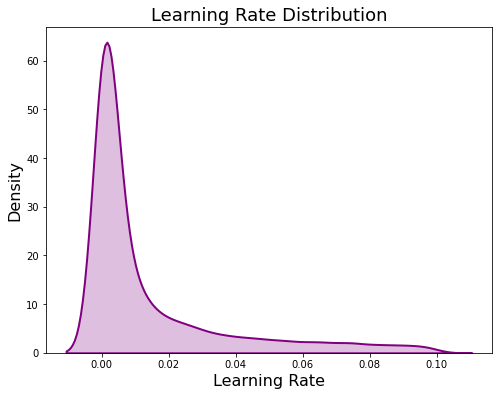

In [17]:
# Investigate a Continues domain distribution

search_space = [
  Real(1e-4, 1e-1, prior='log-uniform', name='learning_rate')
]
# Draw 10000 samples from the learning rate domain
learning_rate_dist = search_space[0].rvs(10000)
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'purple', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

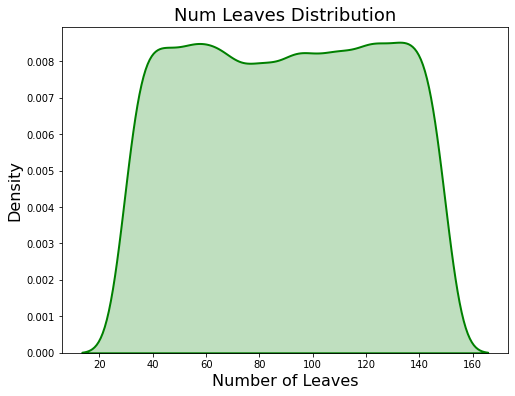

In [18]:
# Investigate a Discrete domain distribution

search_space = [
  Categorical([i for i in range(30, 150)], name='num_leaves')
]
# Draw 10000 samples from the learning rate domain
num_leaves_dist = search_space[0].rvs(10000)
    
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, color = 'green', linewidth = 2, shade = True);
plt.title('Num Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

## Complete Domain

In [19]:
# build entire search_space

 
# Compute the Root Mean Squate Percentage Error
def rmspe(y_true, y_pred, **kwargs):
  return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
  y_true = lgb_train.get_label()
  return 'RMSPE', rmspe(y_true, y_pred), False

estimators_lst = []

train_set = lgb.Dataset(feat, label)
test_set = lgb.Dataset(feat_test, label_test)

search_space = [
  Categorical([i for i in range(20, 150)], name='num_leaves'),
  Categorical([i for i in range(20, 500, 5)], name='min_child_samples'),
  Categorical([i for i in range(10000, 300000, 10000)], name='subsample_for_bin'),
  Real(1e-4, 1e-1, prior='log-uniform', name='learning_rate'),
  Real(0.0, 1.0, name='reg_alpha'),
  Real(0.0, 1.0, name='reg_lambda'),
  Real(0.5, 1.0, name='subsample'),
  Real(0.6, 1.0, name='colsample_by_tree'),
  Categorical([True, False], name='is_unbalance'),
]
 
@use_named_args(search_space)
def evaluate_model(**hyperparameters):
  # First isolate the n_estimators parameter
  if 'n_estimators' in hyperparameters:
    del hyperparameters['n_estimators']
 
  # Make sure that some params take the right type
  for name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
    hyperparameters[name] = int(hyperparameters[name])
 
  kf = KFold(n_splits=N_FOLDS)
 
  # Perform cross validation with early stopping
  cv_results = lgb.cv(
    hyperparameters,
    train_set,
    num_boost_round=1000,
    folds=kf,
    early_stopping_rounds=50,
    feval=feval_rmspe,
    seed = 42
  )
  estimate = cv_results['RMSPE-mean'][-1]
  estimators_lst.append(len(cv_results["RMSPE-mean"]))
  return estimate

In [ ]:
# Run optimization
checkpoint_callback = skopt.callbacks.CheckpointSaver("./result.pkl")

result = gp_minimize(
  evaluate_model,
  search_space,
  acq_func="EI",
  callback=[checkpoint_callback],
  n_calls=50
)

In [25]:
res = load("./result.pkl")

In [28]:
# Best acheived result RMSPE
res.fun

0.29640466779826824

In [29]:
# Best params
res.x

[127,
 445,
 290000,
 0.02591748699123639,
 0.0,
 0.06601415645589061,
 0.5590865469154307,
 0.7064428383863258,
 False]

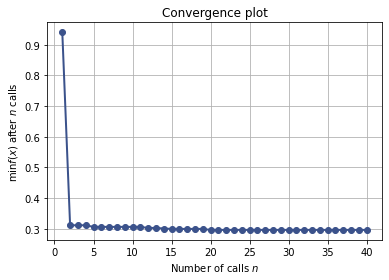

In [39]:
# Plot the convergence of the objective metric
plot_convergence(res)
plt.show()

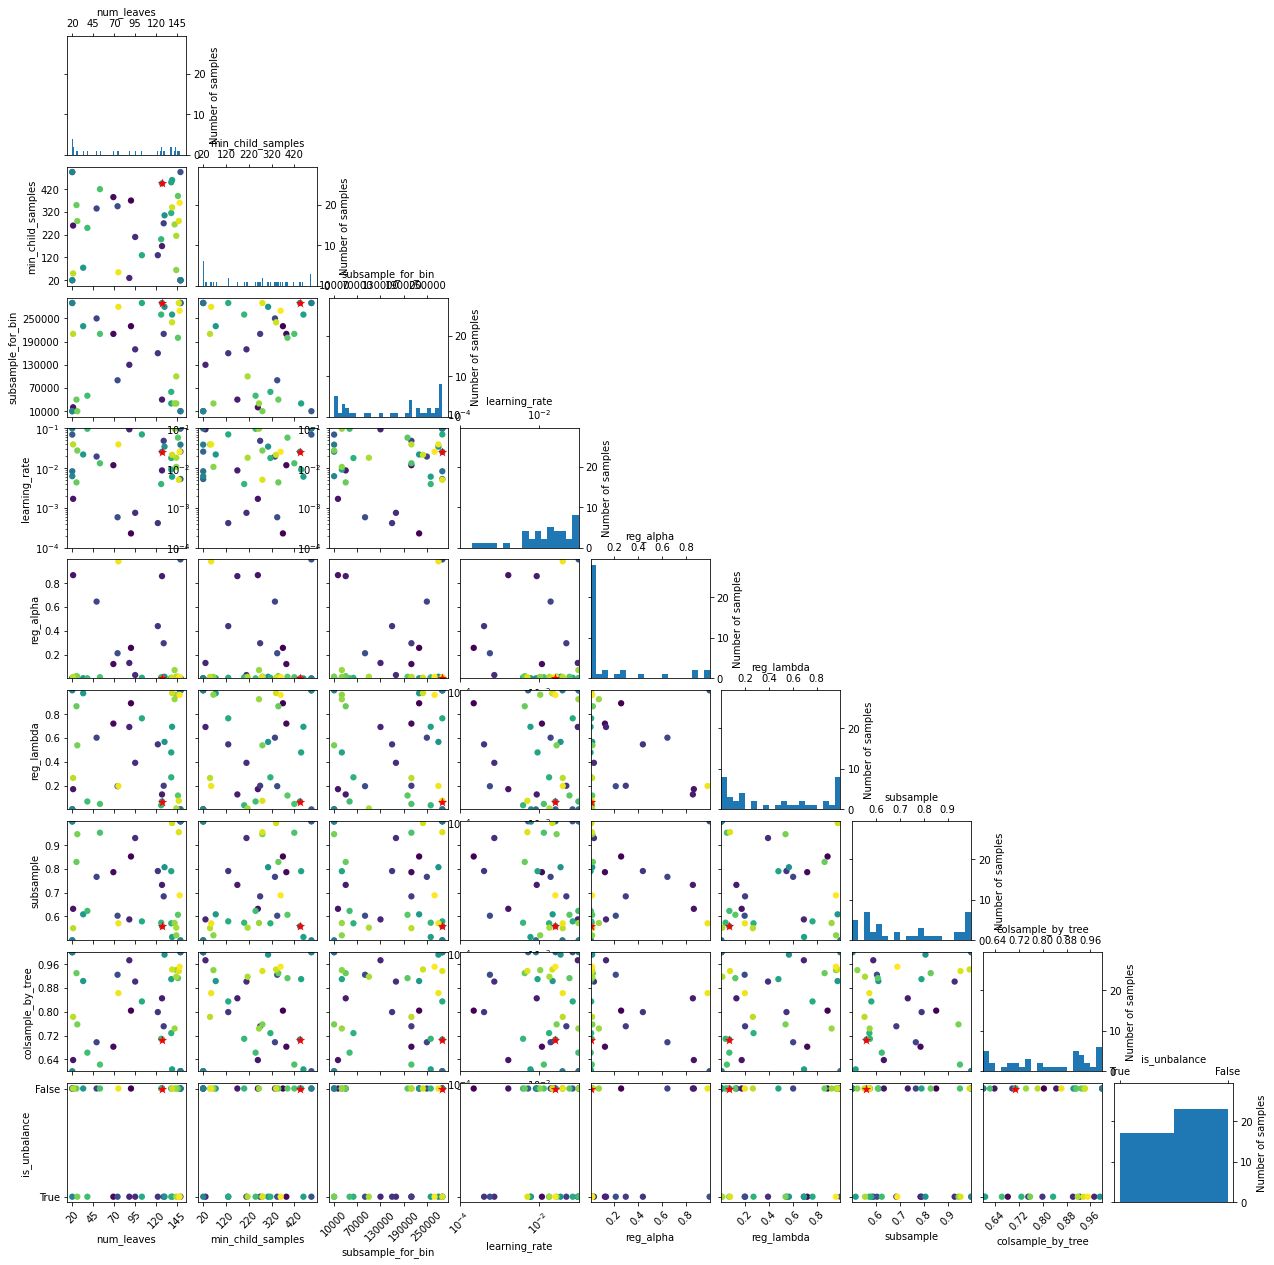

In [56]:
# show dependencies
_ = plot_evaluations(res)